# Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pet_cli.tcms_as_convolutions as pet_tcm
import pet_cli.reference_tissue_models as pet_rtms
from importlib import reload

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.6)
plt.rcParams['font.family'] = 'StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.dpi'] = 72

from scipy.stats import linregress

text_box = dict(facecolor='lightblue', edgecolor='black', lw=2, alpha=0.2)

## Convenience Functions

### Results Formatting

In [ ]:
def calc_diff(true_value, fit_value):
    """
    Calculate the difference and the percentage difference between the real and the new answer.
    
    Args:
        real_answer (float): The real or original answer.
        new_answer (float): The new answer to be compared.
    
    Returns:
        tuple: The new answer, the difference, and the percentage difference.
    """
    diff = fit_value - true_value
    per_d = diff / true_value * 100.
    
    return fit_value, diff, per_d


def print_arrs(pre_str: str, *args):
    """
    Print arrays with a prefix string in a well-formatted manner.

    Args:
        pre_str (str): The prefix string.
        *args: Variable length argument list representing the arrays to be printed.
    """
    print(f"{pre_str + ':':<8}", end=' ')
    for an_arr in args:
        str_arr = [f"{a_num:<5.2f}" for a_num in an_arr]
        print(f"({', '.join(str_arr)})", end='; ')
    print()

### Adding Noise To TACs And Plotting

In [3]:
def add_gaussian_noise_to_tac(tac_vals: np.ndarray, scale: float = 0.2) -> np.ndarray:
    """
    Add Gaussian noise to the given TAC values.

    Args:
        tac_vals (np.ndarray): Original TAC values.
        scale (float): The standard deviation of the Gaussian distribution. Default is 0.2.

    Returns:
        np.ndarray: TAC values with added Gaussian noise.

    Note:
        The first value of output TAC is set to zero. Negative values are also set to 0.
    """
    noise = np.random.normal(loc=0.0, scale=scale, size=tac_vals.shape)
    tac_out = tac_vals + noise
    tac_out[tac_out < 0] = 0.0
    tac_out[0] = 0.0
    return tac_out


def add_gaussian_noise_to_tac_based_on_max(tac_vals: np.ndarray, scale: float = 0.05) -> np.ndarray:
    """
    Add Gaussian noise to the TAC values. The noise is based on the maximum TAC value.

    Args:
        tac_vals (np.ndarray): Original TAC values.
        scale (float): The standard deviation, as a proportion of the maximum TAC value. Default is 0.05.

    Returns:
        np.ndarray: TAC values with added Gaussian noise.

    Note:
        Any negative values in the output TAC are set to zero.
        The first value of output TAC is set to zero. Negative values are also set to 0.
    """
    noise = np.random.normal(loc=0.0, scale=np.max(tac_vals) * scale, size=tac_vals.shape)
    tac_out = tac_vals + noise
    tac_out[tac_out < 0] = 0.0
    tac_out[0] = 0.0
    return tac_out

### Simple Scatter Plots With Regression

In [4]:
def generate_scatter_with_regression_figure(figObj, axObj, fit_values, true_values, ax_titles):
    fAx = axObj.flatten()
    for ax_id, (xAr, yAr, title) in enumerate((zip(true_values.T, fit_values.T, ax_titles))):
        
        x = xAr[~np.isnan(yAr)]
        y = yAr[~np.isnan(yAr)]
        
        lin_reg = linregress(x, y)
        
        fAx[ax_id].plot(x, y, '.', alpha=0.8, color='red')
        
        fAx[ax_id].plot(x, y, '.', alpha=0.8, color='red')
        fAx[ax_id].plot(x, x * lin_reg.slope + lin_reg.intercept, lw=3, color='k', alpha=0.85)
        
        fAx[ax_id].text(0.05, 0.95, fr"$r^2={lin_reg.rvalue:<5.3f}$", fontsize=20, transform=fAx[ax_id].transAxes,
                        ha='left', va='top', bbox=text_box)
        
        fAx[ax_id].set_title(f"{title} Fits", fontweight='bold')
        fAx[ax_id].set(xlabel=fr'True Values', ylabel=fr'Fit Values')



### Bland-Altman Plots

In [5]:
def generate_bland_atlman_figure(figObj, axObj, fit_values, true_values, ax_titles):
    fAx = axObj.flatten()
    for ax_id, (xAr, yAr, title) in enumerate((zip(fit_values.T, true_values.T, ax_titles))):
        x = (xAr + yAr) / 2.0
        y = xAr - yAr
        
        fAx[ax_id].plot(x, y, '.', alpha=0.8, color='red')
        
        mean_diff = np.nanmean(y)
        std_dev = np.nanstd(y)
        mid = mean_diff
        hi = mean_diff + 1.96 * std_dev
        lo = mean_diff - 1.96 * std_dev
        fAx[ax_id].axhline(hi, color='blue', ls='--', zorder=0)
        fAx[ax_id].axhline(lo, color='blue', ls='--', zorder=0)
        fAx[ax_id].axhline(mid, color='k', ls='-', zorder=0)
        
        fAx[ax_id].set_title(f"{title} Fits", fontweight='bold')
        fAx[ax_id].set(xlabel=fr'$\frac{{S_1+S_2}}{{2}}$ (Mean)', ylabel=fr'$S_1-S_2$ (Diff.)')


def generate_ratio_bland_atlman_figure(figObj, axObj, fit_values, true_values, ax_titles):
    fAx = axObj.flatten()
    for ax_id, (xAr, yAr, title) in enumerate((zip(fit_values.T, true_values.T, ax_titles))):
        x = (np.log(xAr) + np.log(yAr)) / 2.0
        y = np.log(xAr) - np.log(yAr)
        
        fAx[ax_id].plot(x, y, '.', alpha=0.8, color='red')
        
        mean_diff = np.nanmean(y)
        std_dev = np.nanstd(y)
        mid = mean_diff
        hi = mean_diff + 1.96 * std_dev
        lo = mean_diff - 1.96 * std_dev
        fAx[ax_id].axhline(hi, color='blue', ls='--', zorder=0)
        fAx[ax_id].axhline(lo, color='blue', ls='--', zorder=0)
        fAx[ax_id].axhline(mid, color='k', ls='-', zorder=0)
        
        fAx[ax_id].set_title(f"{title} Fits", fontweight='bold')
        fAx[ax_id].set(xlabel=fr'$\frac{{\log S_1+\log S_2}}{{2}}$ (Mean)', ylabel=fr'$\log S_1-\log S_2$ (Diff.)')

### Generating Random Samples For Free Parameters

In [6]:
def generate_random_parameter_samples(num_samples, num_params, hi, lo):
    return np.random.random((num_samples, num_params)) * (hi - lo) + lo

### Fitting Large Numbers Of Samples

In [7]:
def calculate_bounded_rtm_fits_from_multiple_parameter_samples(ref_tac_times,
                                                               ref_tac_vals,
                                                               param_samples,
                                                               model_func,
                                                               fit_func,
                                                               start,
                                                               hi,
                                                               lo,
                                                               noise_scale=0.01):
    num_samples, num_params = param_samples.shape
    assert len(param_samples.shape) == 2, "Only implemented for 2-d samples"
    
    fit_vals = np.zeros((num_samples, num_params))
    fit_covs = np.zeros((num_samples, num_params, num_params))
    for tID, t_param in enumerate(param_samples):
        rtm_tac_vals = model_func(ref_tac_times, *t_param, ref_tac_vals)
        if np.min(rtm_tac_vals) < 0.0:
            p_opt = np.nan * np.ones(num_params, float)
            p_cor = np.nan * np.ones((num_params, num_params), float)
        else:
            noisy_tgt_tac_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, noise_scale)
            try:
                bounds = [(start, lo, hi)] * num_params
                p_opt, p_cor = fit_func(noisy_tgt_tac_vals, ref_tac_times, ref_tac_vals, *bounds)
            except RuntimeError:
                p_opt = np.nan * np.ones(num_params, float)
                p_cor = np.nan * np.ones((num_params, num_params), float)
        #                 print("Could not coverge.")
        fit_vals[tID] = p_opt[:] + 0.0
        fit_covs[tID] = p_cor[:] + 0.0
    return fit_vals, fit_covs

In [8]:
def calculate_rtm_fits_from_multiple_parameter_samples(ref_tac_times,
                                                       ref_tac_vals,
                                                       param_samples,
                                                       model_func,
                                                       fit_func,
                                                       noise_scale=0.01):
    num_samples, num_params = param_samples.shape
    assert len(param_samples.shape) == 2, "Only implemented for 2-d samples"
    
    fit_vals = np.zeros((num_samples, num_params))
    fit_covs = np.zeros((num_samples, num_params, num_params))
    for tID, t_param in enumerate(param_samples):
        rtm_tac_vals = model_func(ref_tac_times, *t_param, ref_tac_vals)
        if np.min(rtm_tac_vals) < 0.0:
            p_opt = np.nan * np.ones(num_params, float)
            p_cor = np.nan * np.ones((num_params, num_params), float)
        else:
            noisy_tgt_tac_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, noise_scale)
            try:
                p_opt, p_cor = fit_func(noisy_tgt_tac_vals, ref_tac_times, ref_tac_vals)
            except RuntimeError:
                p_opt = np.nan * np.ones(num_params, float)
                p_cor = np.nan * np.ones((num_params, num_params), float)
        #                 print("Could not coverge.")
        fit_vals[tID] = p_opt[:] + 0.0
        fit_covs[tID] = p_cor[:] + 0.0
    return fit_vals, fit_covs

# Simplified Reference Tissue Model (SRTM)

The analytical solution for the SRTM describes the tissue TAC, $C(t)$, as a function of a reference TAC, $C_\mathrm{R}(t)$, is:
$$
C(t) = R_{1} C_\mathrm{R}(t) + \left( k_{2} - \frac{R_{1}k_{2}}{1+\mathrm{BP_\mathrm{ND}}} \right) C_\mathrm{R}(t)\otimes \exp\left[-\frac{k_{2}}{1+\mathrm{BP_\mathrm{ND}}} t\right].
$$
By defining $\alpha\equiv\frac{k_{2}}{1+\mathrm{BP_\mathrm{ND}}}$, we can rewrite the equation as:
$$
C(t) = R_{1} C_\mathrm{R}(t) + \left( k_{2} - R_{1}\alpha\right) C_\mathrm{R}(t)\otimes \exp\left[-\alpha \cdot t\right].
$$

## Loading An Input Function

In [9]:
input_tac_times, input_tac_vals = np.asarray(np.loadtxt("../../data/tcm_tacs/fdg_plasma_clamp_evenly_resampled.txt").T,
                                             float)
# input_tac_times *= 60.0 #To change time to seconds

## Generating An Example Reference Region
We use a 1TCM with $K_1=1.0$ and $k_2=0.2$.

In [10]:
ref_tac_times, ref_tac_vals = pet_tcm.generate_tac_1tcm_c1_from_tac(tac_times=input_tac_times, tac_vals=input_tac_vals,
                                                                    k1=1.0, k2=0.2)

### Example SRTM TAC
We use $R_1=1.0$, $k_2=0.25$ and $BP=3.0$.

In [11]:
srtm_tac_vals = pet_rtms.calc_srtm_tac(tac_times=ref_tac_times, ref_tac_vals=ref_tac_vals, r1=1.0, k2=0.25, bp=3.0)

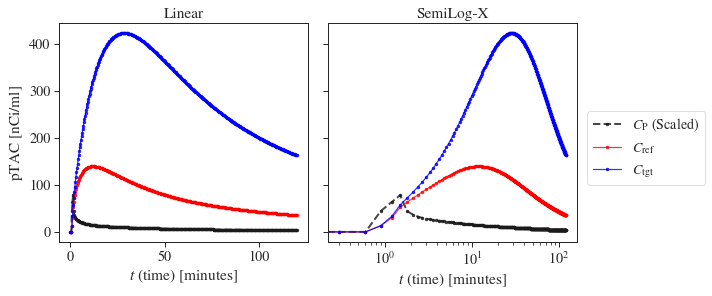

In [12]:
myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 4], sharey=True, dpi=72)
for anAx in myAx.flatten():
    anAx.plot(input_tac_times, input_tac_vals, '.--', alpha=0.8, color='k', label=r'$C_\mathrm{P}$ (Scaled)', lw=2)
    anAx.plot(ref_tac_times, ref_tac_vals, '.-', alpha=0.8, color='red', label=r'$C_\mathrm{ref}$')
    anAx.plot(ref_tac_times, srtm_tac_vals, '.-', alpha=0.8, color='blue', label=r'$C_\mathrm{tgt}$')
    anAx.set(xlabel=r'$t$ (time) [minutes]')
myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left')
plt.show()

## Simple Visual Inspection Of Fits

In [13]:
srtm_test_params = generate_random_parameter_samples(5, 3, hi=3.0, lo=0.001)
srtm_test_params

array([[2.96973306, 0.07878656, 0.23178686],
       [1.8093487 , 0.11731273, 1.19849804],
       [1.98925777, 0.03997731, 0.98497446],
       [1.91115941, 2.56464076, 2.96964839],
       [0.65733846, 1.4185805 , 1.75367959]])

### Plotting Data And Fits Together

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (2.97 , 0.08 , 0.23 ); 
pOpt:    (2.96 , 0.08 , 0.23 ); (-0.01, -0.00, -0.00); (-0.18, -0.76, -0.69); 


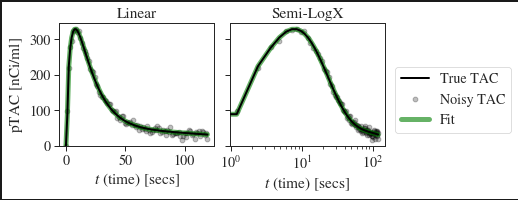

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (1.81 , 0.12 , 1.20 ); 
pOpt:    (1.81 , 0.12 , 1.20 ); (0.00 , 0.00 , 0.00 ); (0.24 , 2.79 , 0.28 ); 


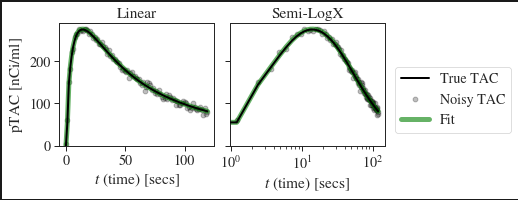

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (1.99 , 0.04 , 0.98 ); 
pOpt:    (1.99 , 0.97 , 0.99 ); (-0.00, 0.93 , 0.00 ); (-0.15, 2331.06, 0.16 ); 


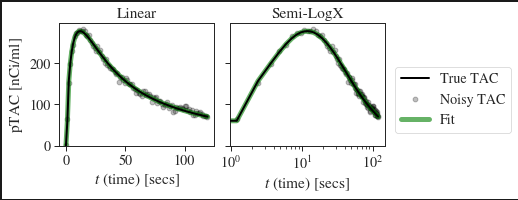

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (1.91 , 2.56 , 2.97 ); 
pOpt:    (1.68 , 2.64 , 2.95 ); (-0.24, 0.07 , -0.02); (-12.34, 2.78 , -0.77); 


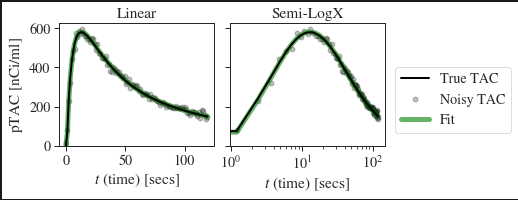

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (0.66 , 1.42 , 1.75 ); 
pOpt:    (0.55 , 1.53 , 1.74 ); (-0.11, 0.12 , -0.02); (-17.04, 8.11 , -1.04); 


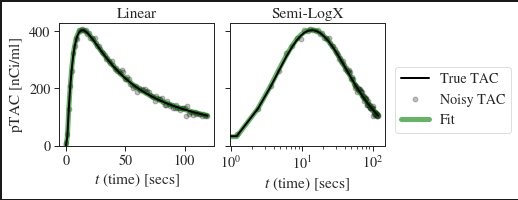

In [14]:
stride = 4
model_func = pet_rtms.calc_srtm_tac
for tID, t_params in enumerate(srtm_test_params[:]):
    rtm_tac_vals = model_func(ref_tac_times, *t_params, ref_tac_vals)
    if np.min(rtm_tac_vals) < 0:
        continue
    print('-' * 80)
    print(f"{'Value':<30};{'Diff':<22};{'%Diff':<32}")
    
    noisy_tgt_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, scale=0.02)
    
    pOpt, pCor = pet_rtms.fit_srtm_to_tac_with_bounds(tgt_tac_vals=noisy_tgt_vals, ref_tac_times=ref_tac_times,
                                                      ref_tac_vals=ref_tac_vals, r1_bounds=(1.0, 0.0001, 10.0),
                                                      k2_bounds=(1.0, 0.0001, 10.0), bp_bounds=(1.0, 0.0001, 10.0))
    print_arrs("Actual", t_params)
    print_arrs("pOpt", *calc_diff(t_params, pOpt))
    
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8 / 1.5, 4 / 1.5], sharey=True, linewidth=3.0,
                               edgecolor='k')
    for anAx in myAx.flatten():
        anAx.plot(ref_tac_times[::stride], rtm_tac_vals[::stride], '-', alpha=1.0, color='black', label=r'True TAC',
                  lw=2.0, zorder=4)
        anAx.plot(ref_tac_times[::stride], noisy_tgt_vals[::stride], 'o', alpha=0.25, color='black', label=r'Noisy TAC')
        yAr = model_func(ref_tac_times, *pOpt, ref_tac_vals)
        anAx.plot(ref_tac_times[::stride], yAr[::stride], '-', alpha=0.6, color='green', lw=5, label='Fit')
    
    leg_hands, leg_labs = list(myAx[0].get_legend_handles_labels())
    
    myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear', ylim=(-0.25, None), xlabel='$t$ (time) [secs]')
    myAx[1].set(xscale='log', ylim=(-0.0001, None), title='Semi-LogX', xlabel='$t$ (time) [secs]')
    
    myFig.legend(leg_hands, leg_labs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    plt.show()


## Generating A Simple Scatter Plot Of Fits vs. Real Values From Many Random Values

### Unbounded Fits

#### Generating Random Samples

In [15]:
num_samples = 5000

srtm_test_params_large = generate_random_parameter_samples(num_samples=num_samples, num_params=3, hi=3.0, lo=0.001)
srtm_fits_unbounded, srtm_fit_covs_unbounded = calculate_rtm_fits_from_multiple_parameter_samples(
    ref_tac_times=ref_tac_times, ref_tac_vals=ref_tac_vals, param_samples=srtm_test_params_large,
    model_func=pet_rtms.calc_srtm_tac, fit_func=pet_rtms.fit_srtm_to_tac, noise_scale=0.01)

#### Scatter Plot

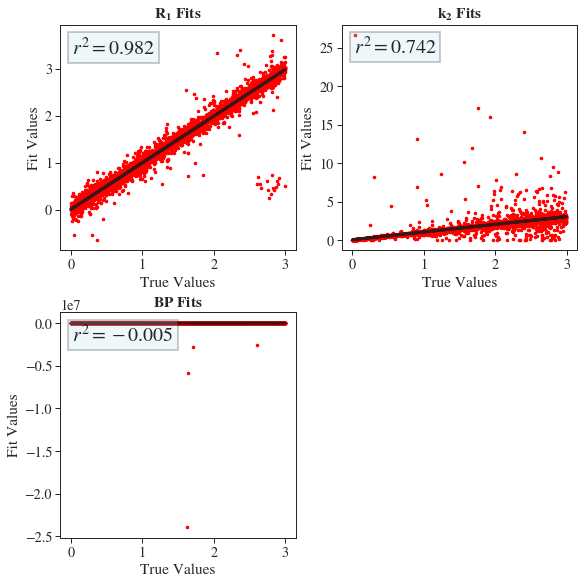

In [16]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True)
generate_scatter_with_regression_figure(figObj=myFig, axObj=myAx, fit_values=srtm_fits_unbounded,
                                        true_values=srtm_test_params_large,
                                        ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{BP}$'])
myAx[-1, -1].axis('off')
# myFig.suptitle("Unbounded Fits For SRTM Can Perform Very Poorly", color='darkgreen')
plt.show()

#### Bland-Altman Plot

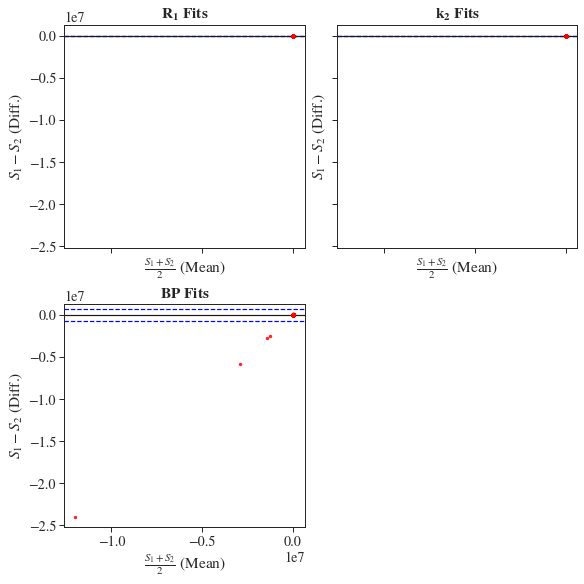

In [17]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True, sharex=True, sharey=True)
generate_bland_atlman_figure(figObj=myFig, axObj=myAx, fit_values=srtm_fits_unbounded,
                             true_values=srtm_test_params_large,
                             ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{BP}$'])
myAx[-1, -1].axis('off')
plt.show()

#### Ratio Bland Altman Plot

/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_10095/3882928641.py:26: RuntimeWarning: invalid value encountered in log
  x = (np.log(xAr) + np.log(yAr)) / 2.0
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_10095/3882928641.py:27: RuntimeWarning: invalid value encountered in log
  y = np.log(xAr) - np.log(yAr)


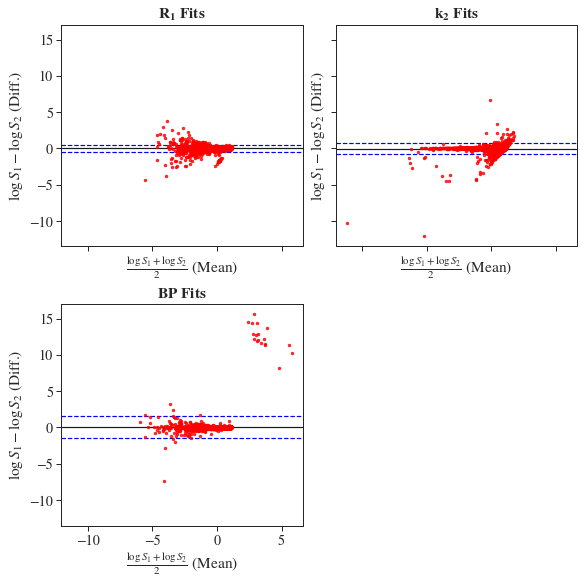

In [18]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True, sharex=True, sharey=True)
generate_ratio_bland_atlman_figure(figObj=myFig, axObj=myAx, fit_values=srtm_fits_unbounded,
                                   true_values=srtm_test_params_large,
                                   ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{BP}$'])
myAx[-1, -1].axis('off')
plt.show()

### Bounded Fits

#### Generating Random Samples

In [19]:
srtm_fits_bounded, srtm_fit_covs_bounded = calculate_bounded_rtm_fits_from_multiple_parameter_samples(
    ref_tac_times=ref_tac_times, ref_tac_vals=ref_tac_vals, param_samples=srtm_test_params_large,
    model_func=pet_rtms.calc_srtm_tac, fit_func=pet_rtms.fit_srtm_to_tac_with_bounds, noise_scale=0.01, start=0.5,
    hi=4.0, lo=0.0)

#### Scatter Plot

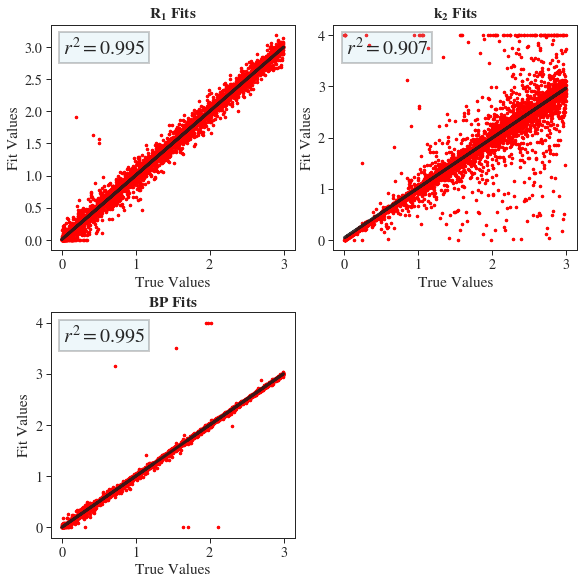

In [20]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True)
generate_scatter_with_regression_figure(figObj=myFig, axObj=myAx, fit_values=srtm_fits_bounded,
                                        true_values=srtm_test_params_large,
                                        ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{BP}$'])
myAx[-1, -1].axis('off')
# myFig.suptitle("Bounded Fits For SRTM Fit $R_1$ And $\mathrm{BP}$ Better Than $k_2$", color='darkgreen')
plt.show()

#### Bland-Altman Plot

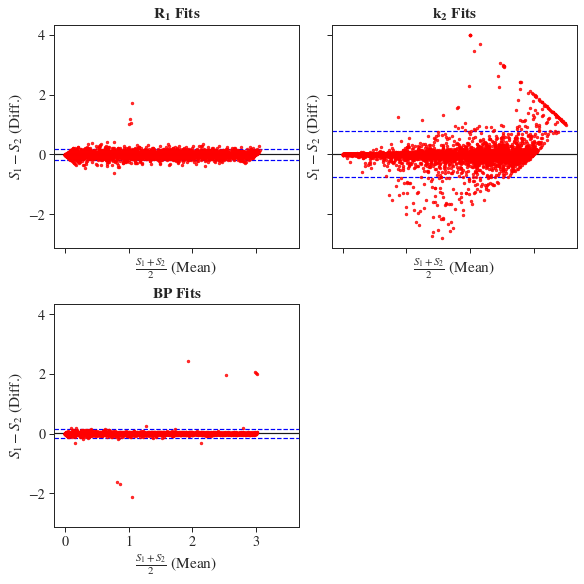

In [21]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True, sharex=True, sharey=True)
generate_bland_atlman_figure(figObj=myFig, axObj=myAx, fit_values=srtm_fits_bounded, true_values=srtm_test_params_large,
                             ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{BP}$'])
myAx[-1, -1].axis('off')
plt.show()

#### Ratio Bland Altman Plot

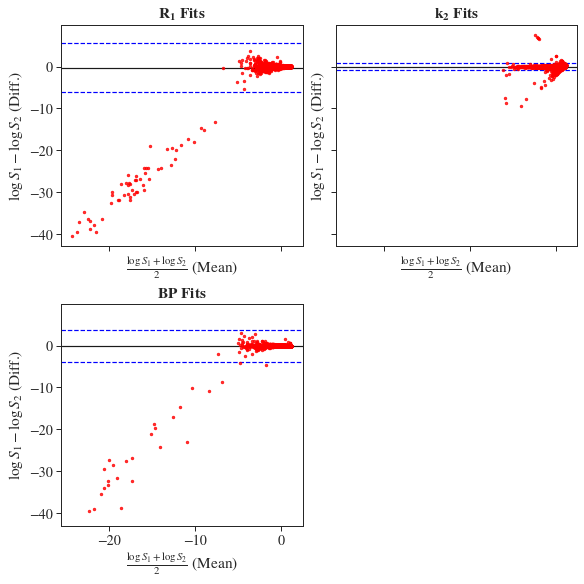

In [22]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True, sharex=True, sharey=True)
generate_ratio_bland_atlman_figure(figObj=myFig, axObj=myAx, fit_values=srtm_fits_bounded,
                                   true_values=srtm_test_params_large,
                                   ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{BP}$'])
myAx[-1, -1].axis('off')
plt.show()

# Full Reference Tissue Model (FRTM)

Given, $R_{1}\equiv \frac{k_{1}^{\prime}}{k_{1}^{\prime}}$, the analytical solution for the FRTM, as a function of some reference region TAC, $C_\mathrm{R}(t)$, can be written as:
$$
C(t) = R_{1}C_\mathrm{R}(t) + \left[ A_{1}e^{-\alpha_{1}t} + A_{2}e^{-\alpha_{2}t} \right] \otimes C_\mathrm{R}(t),
$$
where the $\alpha_1$, $\alpha_2$, $A_1$, and $A_2$ depend on the underlying kinetic constants $k_2$, $k_3$, $k_4$, along with the predefined $R_1$, as:
$$
\begin{align}
\alpha_{1} &= \frac{k_{2} + k_{3} + k_{4} - \sqrt{\left( k_{2} + k_{3} + k_{4} \right)^2 - 4k_{2}k_{4}}}{2}\\
\alpha_{2} &= \frac{k_{2} + k_{3} + k_{4} + \sqrt{\left( k_{2} + k_{3} + k_{4} \right)^2 - 4k_{2}k_{4}}}{2}\\
A_{1} &= \left( \frac{k_{3} + k_{4} -\alpha_{2}}{\alpha_{1} - \alpha_{2}} \right)\left( \frac{k_{2}}{R_{1}} - \alpha_{2} \right)\\
A_{2} &= \left(  \frac{\alpha_{1}-k_{3} - k_{4} }{\alpha_{1} - \alpha_{2}} \right)\left( \frac{k_{2}}{R_{1}} - \alpha_{1} \right)
\end{align}
$$
Here, we can define $\beta\equiv k_{2} + k_{3} +k_{4}$, and $\chi\equiv\sqrt{\beta^2 - 4k_{2}k_{4}}$ to make the $\alpha$'s more compact:
$$
\begin{align}
\alpha_{1} &= \frac{\beta - \chi}{2}\\
\alpha_{2} &= \frac{\beta + \chi}{2}\\
A_{1} &= \left(\frac{k_{3} + k_{4} -\alpha_{2}}{\chi} \right)\left( \frac{k_{2}}{R_{1}} - \alpha_{2} \right)\\
A_{2} &= \left(\frac{\alpha_{1}-k_{3} - k_{4} }{\chi} \right)\left( \frac{k_{2}}{R_{1}} - \alpha_{1} \right)
\end{align}
$$


## Generating An Example Reference Region
We use a 1TCM with $K_1=1.0$ and $k_2=0.1$.

In [23]:
ref_tac_times, ref_tac_vals = pet_tcm.generate_tac_1tcm_c1_from_tac(tac_times=input_tac_times, tac_vals=input_tac_vals,
                                                                    k1=1.0, k2=0.1)

### Example FRTM TAC
We use $R_1=0.5$, $k_2=0.01$, $k_3=0.3$ and $k_4=0.01$.

In [24]:
frtm_test_params = np.asarray((0.5, 0.01, 0.3, 0.01))
frtm_tac_vals = pet_rtms.calc_frtm_tac(tac_times=ref_tac_times, ref_tac_vals=ref_tac_vals, r1=0.5, k2=0.01, k3=0.3,
                                       k4=0.01)


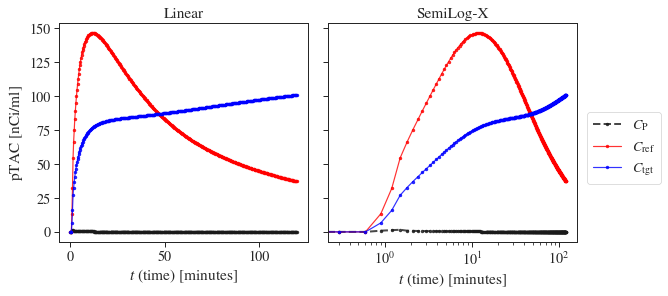

In [25]:
myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(input_tac_times, input_tac_vals / 50., '.--', alpha=0.8, color='k', label=r'$C_\mathrm{P}$', lw=2)
    anAx.plot(ref_tac_times, ref_tac_vals, '.-', alpha=0.8, color='red', label=r'$C_\mathrm{ref}$')
    anAx.plot(ref_tac_times, frtm_tac_vals, '.-', alpha=0.8, color='blue', label=r'$C_\mathrm{tgt}$')
    anAx.set(xlabel=r'$t$ (time) [minutes]')
myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left')
plt.show()

## Simple Visual Inspection Of Fits

### Generating Ramdom Samples For The Parameters

In [37]:
frtm_test_params = generate_random_parameter_samples(num_samples=5, num_params=4, hi=5.0, lo=0.001)
frtm_test_params

array([[3.12722121, 4.51021502, 3.90315147, 0.45493909],
       [0.779232  , 1.8075845 , 4.95800322, 3.69388584],
       [2.22406948, 2.61805457, 0.56233611, 1.91286162],
       [2.21762251, 4.43195382, 2.32024232, 4.95654127],
       [1.94247657, 3.43841136, 3.38900859, 0.40071575]])

### Plotting Data And Fits Together

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (1.85 , 0.07 , 4.18 , 0.21 ); 
pOpt:    (1.85 , 0.07 , 5.43 , 0.27 ); (-0.00, -0.00, 1.25 , 0.06 ); (-0.08, -0.92, 29.98, 27.06); 


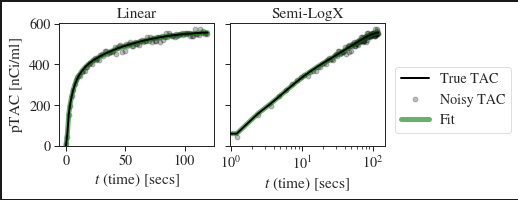

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (2.09 , 0.63 , 0.51 , 4.22 ); 
pOpt:    (2.14 , 0.53 , 0.13 , 2.57 ); (0.05 , -0.10, -0.38, -1.65); (2.32 , -15.86, -74.85, -39.15); 


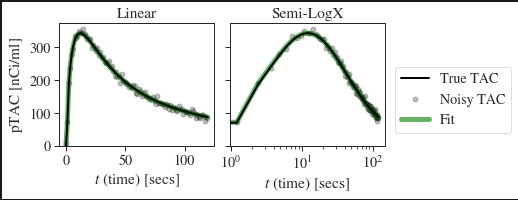

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (3.99 , 3.02 , 1.79 , 3.76 ); 
pOpt:    (4.17 , 2.95 , 2.97 , 6.00 ); (0.18 , -0.07, 1.18 , 2.24 ); (4.51 , -2.34, 65.65, 59.57); 


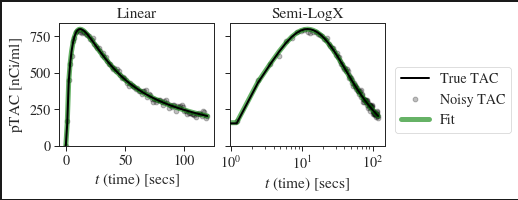

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (0.59 , 0.80 , 2.77 , 2.73 ); 
pOpt:    (0.59 , 0.79 , 2.74 , 2.73 ); (0.00 , -0.00, -0.03, 0.00 ); (0.55 , -0.36, -1.13, 0.09 ); 


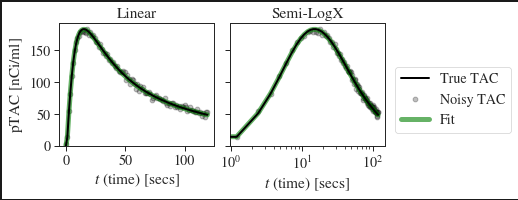

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (3.67 , 1.94 , 3.38 , 1.78 ); 
pOpt:    (3.99 , 1.58 , 6.00 , 3.03 ); (0.32 , -0.35, 2.62 , 1.25 ); (8.76 , -18.18, 77.63, 70.04); 


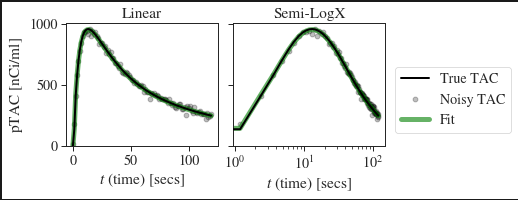

In [27]:
stride = 4  # To reduce the number of shown points for clarity
model_func = pet_rtms.calc_frtm_tac
for tID, t_params in enumerate(frtm_test_params[:]):
    rtm_tac_vals = model_func(ref_tac_times, *t_params, ref_tac_vals)
    if np.min(rtm_tac_vals) < 0:
        continue
    print('-' * 80)
    print(f"{'Value':<37};{'Diff':<29};{'%Diff':<32}")
    
    noisy_tgt_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, scale=0.02)
    
    pOpt, pCor = pet_rtms.fit_frtm_to_tac_with_bounds(tgt_tac_vals=noisy_tgt_vals, ref_tac_times=ref_tac_times,
                                                      ref_tac_vals=ref_tac_vals, r1_bounds=(1.0, 0.0001, 6.0),
                                                      k2_bounds=(1.0, 0.0001, 6.0), k3_bounds=(1.0, 0.0001, 6.0),
                                                      k4_bounds=(1.0, 0.0001, 6.0))
    print_arrs("Actual", t_params)
    print_arrs("pOpt", *calc_diff(t_params, pOpt))
    
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8 / 1.5, 4 / 1.5], sharey=True, linewidth=3.0,
                               edgecolor='k')
    for anAx in myAx.flatten():
        anAx.plot(ref_tac_times[::stride], rtm_tac_vals[::stride], '-', alpha=1.0, color='black', label=r'True TAC',
                  lw=2.0, zorder=4)
        anAx.plot(ref_tac_times[::stride], noisy_tgt_vals[::stride], 'o', alpha=0.25, color='black', label=r'Noisy TAC')
        yAr = model_func(ref_tac_times, *pOpt, ref_tac_vals)
        anAx.plot(ref_tac_times[::stride], yAr[::stride], '-', alpha=0.6, color='green', lw=5, label='Fit')
    
    leg_hands, leg_labs = list(myAx[0].get_legend_handles_labels())
    
    myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear', ylim=(-0.25, None), xlabel='$t$ (time) [secs]')
    myAx[1].set(xscale='log', ylim=(-0.0001, None), title='Semi-LogX', xlabel='$t$ (time) [secs]')
    
    myFig.legend(leg_hands, leg_labs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    plt.show()


## Generating A Simple Scatter Plot Of Fits vs. Real Values From Many Random Values

### Unbounded Fits

#### Generating Random Samples

In [28]:
frtm_test_params_large = generate_random_parameter_samples(num_samples=100, num_params=4, hi=3.0, lo=0.01)

In [29]:
num_samples = 5000

frtm_test_params_large = generate_random_parameter_samples(num_samples=num_samples, num_params=4, hi=3.0, lo=0.001)
frtm_fits_unbounded, frtm_fit_covs_unbounded = calculate_rtm_fits_from_multiple_parameter_samples(
    ref_tac_times=ref_tac_times, ref_tac_vals=ref_tac_vals, param_samples=frtm_test_params_large,
    model_func=pet_rtms.calc_frtm_tac, fit_func=pet_rtms.fit_frtm_to_tac, noise_scale=0.01)

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/pet_cli/reference_tissue_models.py:100: RuntimeWarning: overflow encountered in exp
  exp_funcs = a1 * np.exp(-alpha_1 * tac_times) + a2 * np.exp(-alpha_2 * tac_times)
/Users/furqandar/Library/Python/3.9/lib/python/site-packages/pet_cli/reference_tissue_models.py:146: RuntimeWarning: invalid value encountered in sqrt
  chi = np.sqrt(beta ** 2. - 4.0 * k2 * k4)
/Users/furqandar/Library/Python/3.9/lib/python/site-packages/pet_cli/reference_tissue_models.py:100: RuntimeWarning: overflow encountered in multiply
  exp_funcs = a1 * np.exp(-alpha_1 * tac_times) + a2 * np.exp(-alpha_2 * tac_times)
/Users/furqandar/Library/Python/3.9/lib/python/site-packages/pet_cli/reference_tissue_models.py:100: RuntimeWarning: invalid value encountered in add
  exp_funcs = a1 * np.exp(-alpha_1 * tac_times) + a2 * np.exp(-alpha_2 * tac_times)
/Users/furqandar/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWar

#### Scatter Plot

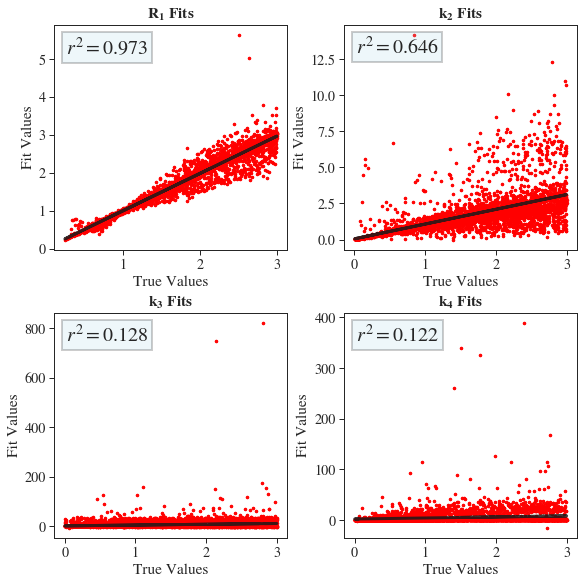

In [30]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True)
generate_scatter_with_regression_figure(figObj=myFig, axObj=myAx, fit_values=frtm_fits_unbounded,
                                        true_values=frtm_test_params_large,
                                        ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{k_3}$',
                                                   r'$\mathbf{k_4}$'])
# myFig.suptitle("Unbounded Fits For SRTM Can Perform Very Poorly", color='darkgreen')
plt.show()

#### Bland-Altman Plot

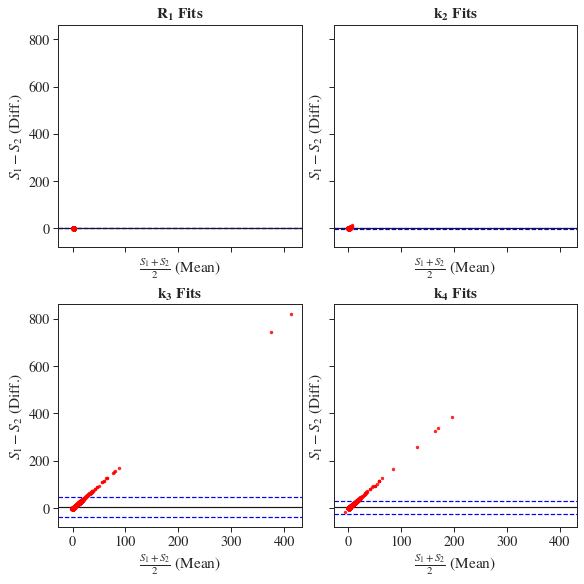

In [31]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True, sharex=True, sharey=True)
generate_bland_atlman_figure(figObj=myFig, axObj=myAx, fit_values=frtm_fits_unbounded,
                             true_values=frtm_test_params_large,
                             ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{k_3}$', r'$\mathbf{k_4}$'])
plt.show()

#### Ratio Bland Altman Plot

/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_10095/3882928641.py:26: RuntimeWarning: invalid value encountered in log
  x = (np.log(xAr) + np.log(yAr)) / 2.0
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_10095/3882928641.py:27: RuntimeWarning: invalid value encountered in log
  y = np.log(xAr) - np.log(yAr)


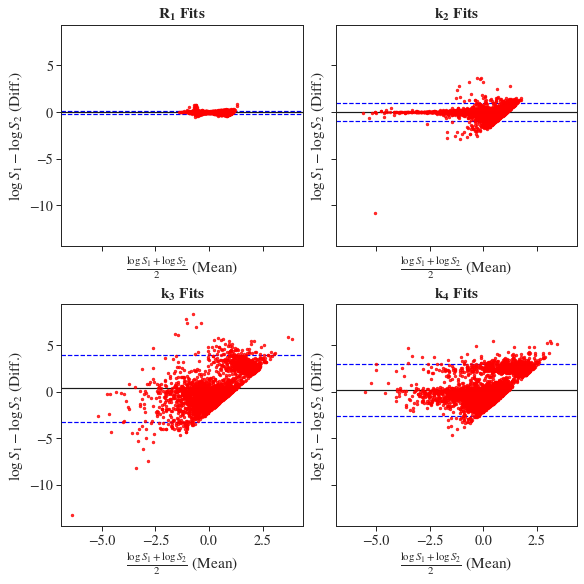

In [32]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True, sharex=True, sharey=True)
generate_ratio_bland_atlman_figure(figObj=myFig, axObj=myAx, fit_values=frtm_fits_unbounded,
                                   true_values=frtm_test_params_large,
                                   ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{k_3}$',
                                              r'$\mathbf{k_4}$'])
plt.show()

### Bounded Fits

#### Fitting The Random Samples

In [33]:
frtm_fits_bounded, frtm_fit_covs_bounded = calculate_bounded_rtm_fits_from_multiple_parameter_samples(
        ref_tac_times=ref_tac_times, ref_tac_vals=ref_tac_vals, param_samples=frtm_test_params_large,
        model_func=pet_rtms.calc_frtm_tac, fit_func=pet_rtms.fit_frtm_to_tac_with_bounds, noise_scale=0.01, start=0.5,
        hi=5.0, lo=0.0)

#### Scatter Plot

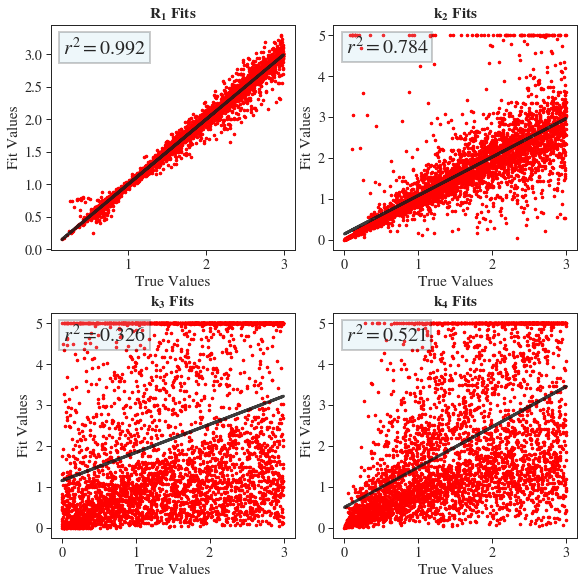

In [34]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True)
generate_scatter_with_regression_figure(figObj=myFig, axObj=myAx, fit_values=frtm_fits_bounded,
                                        true_values=frtm_test_params_large,
                                        ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{k_3}$',
                                                   r'$\mathbf{k_4}$'])
# myFig.suptitle("Unbounded Fits For SRTM Can Perform Very Poorly", color='darkgreen')
plt.show()

#### Bland-Altman Plot

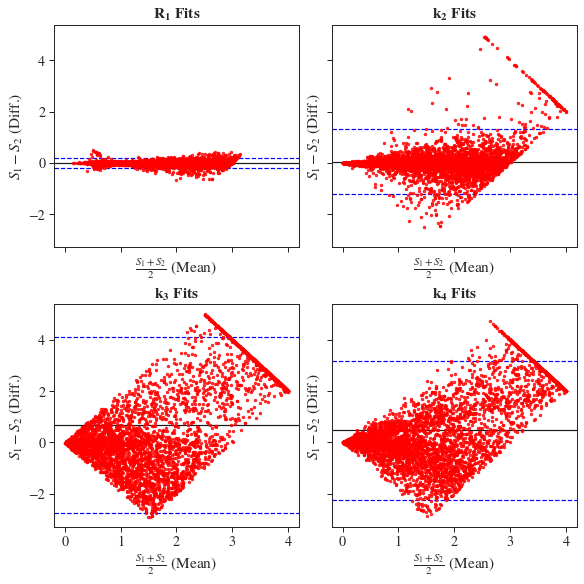

In [35]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True, sharex=True, sharey=True)
generate_bland_atlman_figure(figObj=myFig, axObj=myAx, fit_values=frtm_fits_bounded, true_values=frtm_test_params_large,
                             ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{k_3}$', r'$\mathbf{k_4}$'])
plt.show()

#### Ratio Bland Altman Plot

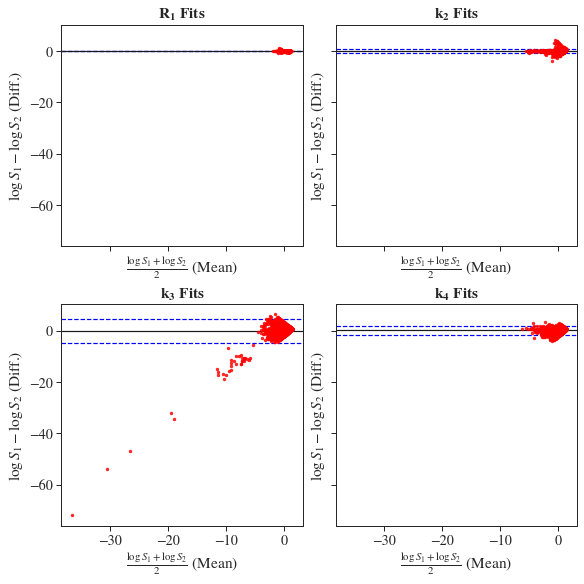

In [36]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True, sharex=True, sharey=True)
generate_ratio_bland_atlman_figure(figObj=myFig, axObj=myAx, fit_values=frtm_fits_bounded,
                                   true_values=frtm_test_params_large,
                                   ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{k_3}$',
                                              r'$\mathbf{k_4}$'])
plt.show()